In [62]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Open annotated propaganda tweets

In [2]:
# file available upon request
with open('../../../data/tweets_vips_annotated.json') as f:
    propaganda_tweets = json.load(f)

Open file with political representatives handles

In [3]:
# file available upon request
vips = pd.read_csv("../../../data/twitter_representatives_handles_final.csv")

Add info on author and party to annotated tweets

In [4]:
tweets = []
for tweet in propaganda_tweets:
    tweet_id = tweet
    created_at = propaganda_tweets[tweet]['created_at']
    author_id = propaganda_tweets[tweet]['author_id']
    Party = vips[vips['ids'] == author_id]['Party'].values[0]
    if "annotations" not in propaganda_tweets[tweet]:
        continue
    annotations = [sub["label"] for sub in propaganda_tweets[tweet]['annotations']]
    tweets.append([tweet_id, created_at, author_id, Party, annotations])

df = pd.DataFrame(tweets, columns=['tweet_id', 'created_at', 'author_id', 'Party', 'annotations'])

Define reference swing periods

In [5]:
start_before = '2022-07-01'
start_during = '2022-08-26'
start_after = '2022-09-25'
end_after = '2022-10-31'

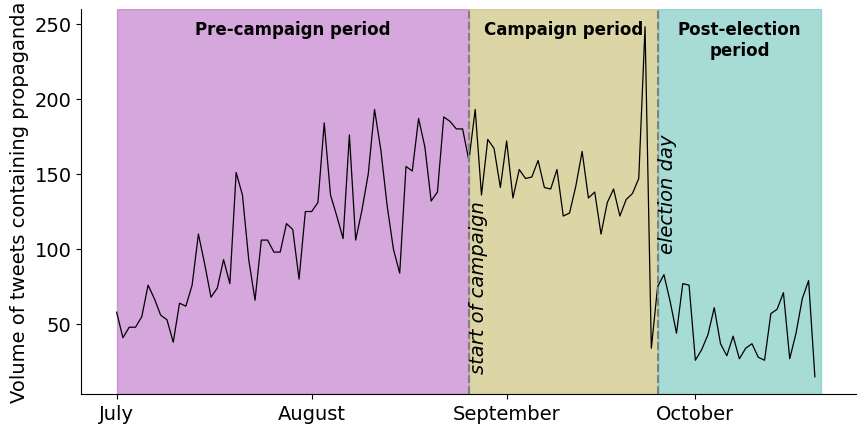

In [33]:
# define figure size
plt.figure(figsize=(10, 5))

# lineplot of number of tweets by day
sns.lineplot(data=df.groupby('created_at').size(), color='black', linewidth=0.9)
plt.axvline(start_during, color='grey', linestyle='--')
plt.axvline(start_after, color='grey', linestyle='--')

# annotate the plot
plt.text(start_during, 20, 'start of campaign', rotation=90, style='italic', size=14)
plt.text(start_after, 100, 'election day', rotation=90, style='italic', size=14)

plt.ylabel('Volume of tweets containing propaganda', size=14)
plt.xlabel('')

plt.xticks(ticks=['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01'],
           labels=['July', 'August', 'September', 'October'],
           size=14) 

# yticks size
plt.yticks(size=14)

# add annotation of "Pre-campaign period", "Campaign period", "Post-election period"
plt.axvspan(start_before, start_during, alpha=0.6, color='#BC6DC5')
plt.axvspan(start_during, start_after, alpha=0.6, color='#C5BC6D')
plt.axvspan(start_after, end_after, alpha=0.6, color='#6DC5BC')
 
plt.text('2022-07-29', 243, 'Pre-campaign period', rotation=0, color='black', fontsize=12, fontweight='bold', ha='center')
plt.text('2022-09-10', 243, 'Campaign period', rotation=0, color='black', fontsize=12, fontweight='bold', ha='center')
plt.text('2022-10-08', 229, 'Post-election\nperiod', rotation=0, color='black', fontsize=12, fontweight='bold', ha='center')

sns.despine()

plt.show()



In [35]:
# create "period" column conditional on created_at
df['period'] = 'before'
df.loc[df['created_at'] >= start_during, 'period'] = 'during'
df.loc[df['created_at'] >= start_after, 'period'] = 'after'

In [36]:
df["unique_annotations"] = df["annotations"]

# Techniques by period

In [37]:
# subset dataframes for each period
before = df[df['period'] == 'before']
during = df[df['period'] == 'during']
after = df[df['period'] == 'after']

In [38]:
print(len(before), len(during), len(after))

6243 4343 1263


In [39]:
# count unique annotations for each period
before_annotations = before['unique_annotations'].explode().value_counts()
during_annotations = during['unique_annotations'].explode().value_counts()
after_annotations = after['unique_annotations'].explode().value_counts()

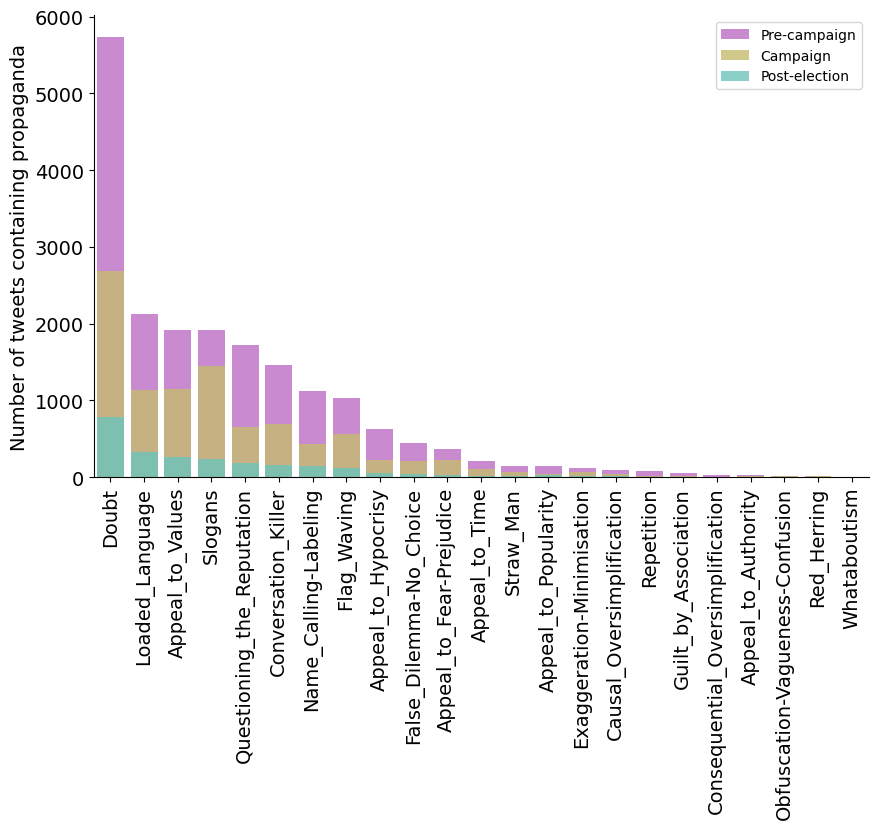

In [45]:
# plot annotations with dots
plt.figure(figsize=(10, 6))
# barplot
sns.barplot(x=before_annotations.index, y=before_annotations.values, color='#BC6DC5', label='Pre-campaign', alpha=0.8, saturation=1)
sns.barplot(x=during_annotations.index, y=during_annotations.values, color='#C5BC6D', label='Campaign', alpha=0.8, saturation=1)
sns.barplot(x=after_annotations.index, y=after_annotations.values, color='#6DC5BC', label='Post-election', alpha=0.8, saturation=1)

plt.ylabel('Number of tweets containing propaganda', size=14)

plt.xlabel('')

# legend and labels
plt.legend();
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)

# despine
sns.despine()

# Technique by party

In [63]:
# compute baseline of % of tweets containing each annotation
total_tweets = len(df)
total_annotations = df['annotations'].explode().count()
baseline = df['unique_annotations'].explode().value_counts() / total_annotations
baseline

Doubt                               0.290593
Loaded_Language                     0.113754
Slogans                             0.113407
Appeal_to_Values                    0.105099
Questioning_the_Reputation          0.080585
Conversation_Killer                 0.072719
Flag_Waving                         0.053955
Name_Calling-Labeling               0.053702
Appeal_to_Hypocrisy                 0.028589
False_Dilemma-No_Choice             0.022113
Appeal_to_Fear-Prejudice            0.019649
Appeal_to_Time                      0.010930
Straw_Man                           0.007202
Appeal_to_Popularity                0.006792
Exaggeration-Minimisation           0.006350
Causal_Oversimplification           0.004486
Repetition                          0.002843
Guilt_by_Association                0.002464
Appeal_to_Authority                 0.001327
Consequential_Oversimplification    0.001264
Obfuscation-Vagueness-Confusion     0.001232
Red_Herring                         0.000758
Whatabouti

<Figure size 1000x2000 with 0 Axes>

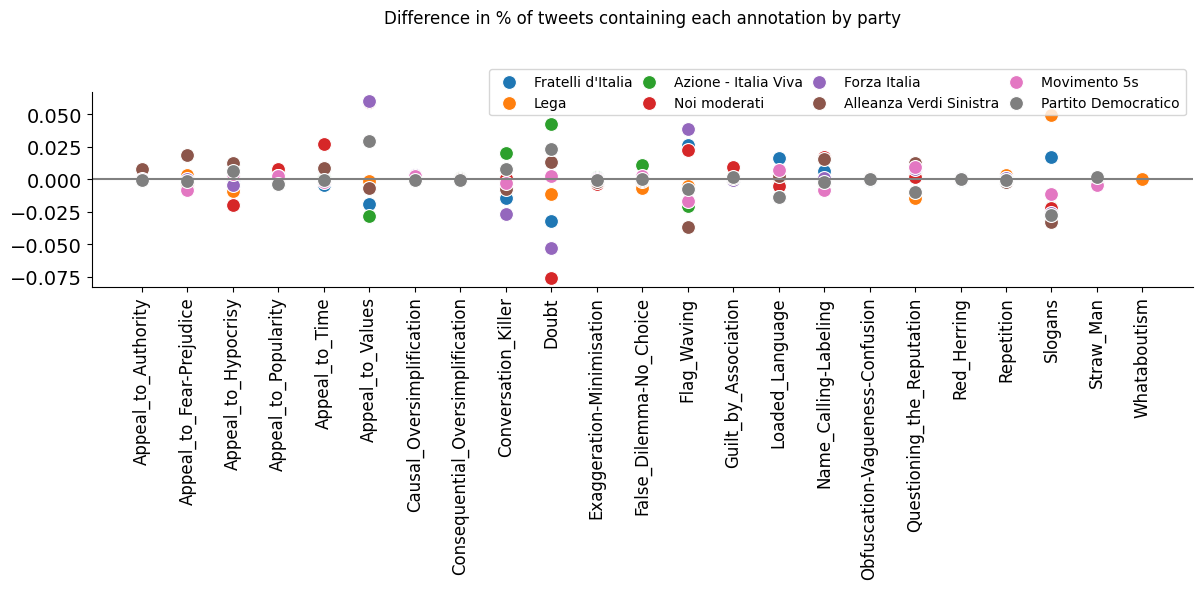

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size so that there is more space for the legend
plt.figure(figsize=(10, 20))


# Initialize empty dictionaries to store data for each party
party_diffs = {}
party_annotations_percs = {}

# Iterate over unique parties
for party in df["Party"].unique():
    party_annotations = df[df["Party"] == party]["unique_annotations"].explode().value_counts()

    # Compute % of tweets containing each annotation by party
    party_annotations_tot = df[df["Party"] == party]["unique_annotations"].explode().count()
    party_annotations_perc = party_annotations / party_annotations_tot

    # Store party annotations percentages
    party_annotations_percs[party] = party_annotations_perc

    # Compute the difference between party_annotations_perc and baseline
    party_diff = party_annotations_perc - baseline

    # Store party differences
    party_diffs[party] = party_diff

# Plot all parties with multiple lines and colors
plt.figure(figsize=(12, 6))

for party, diff in party_diffs.items():
    # Lineplot for each party
    sns.scatterplot(x=diff.index, y=diff.values, label=party, marker='o', s=100)

plt.title('Difference in % of tweets containing each annotation by party', pad=50)
plt.xticks(rotation=90, size=12)
plt.yticks(size=14)
plt.axhline(0, color='grey')  # Add line at 0
# plt.axhline(0.1, color='grey', linestyle='--')  # Add dashed lines at 0.1 and -0.1
# plt.axhline(-0.1, color='grey', linestyle='--')

plt.xlabel('')

# remove all spines except for the left one
sns.despine(left=False)


# Horizontal legend outside the plot
plt.legend(loc='center right', bbox_to_anchor=(1, 1), ncol=4, columnspacing=0.2)
plt.tight_layout()
plt.show()


# Techniques by party and period

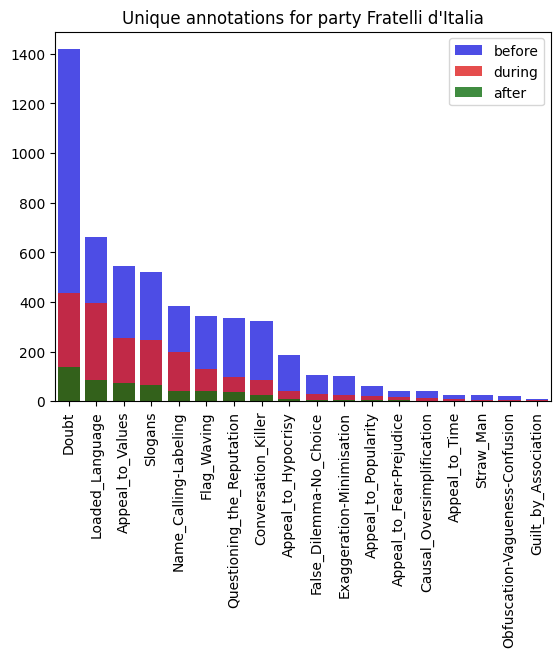

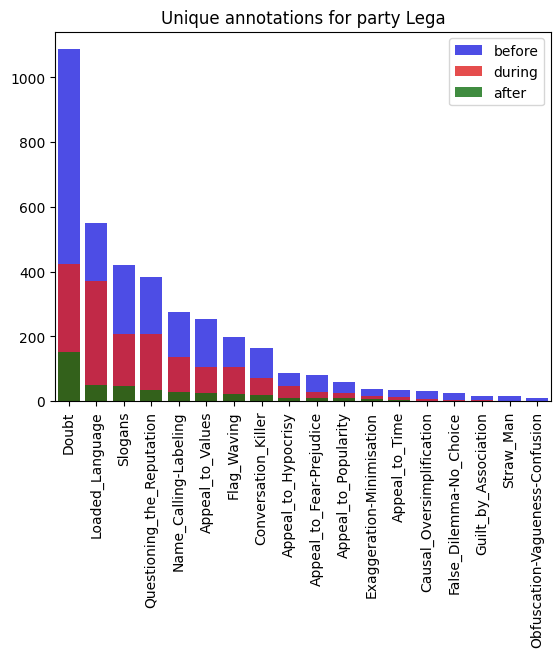

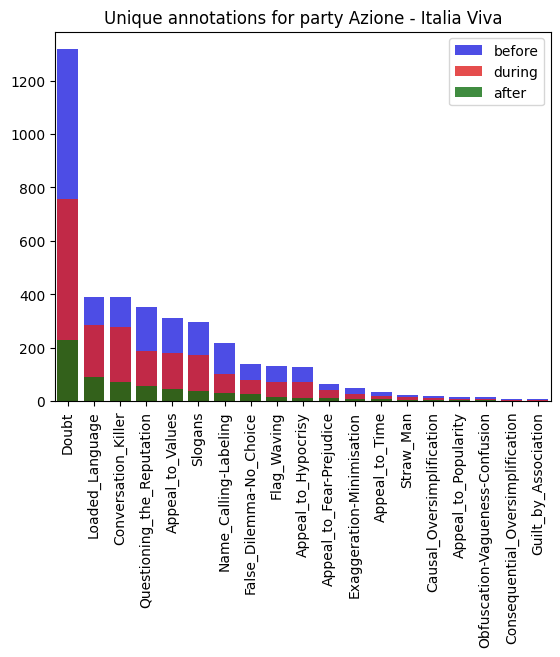

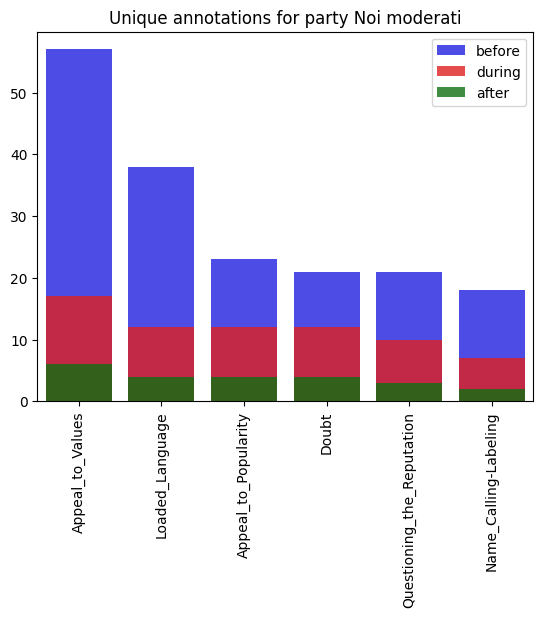

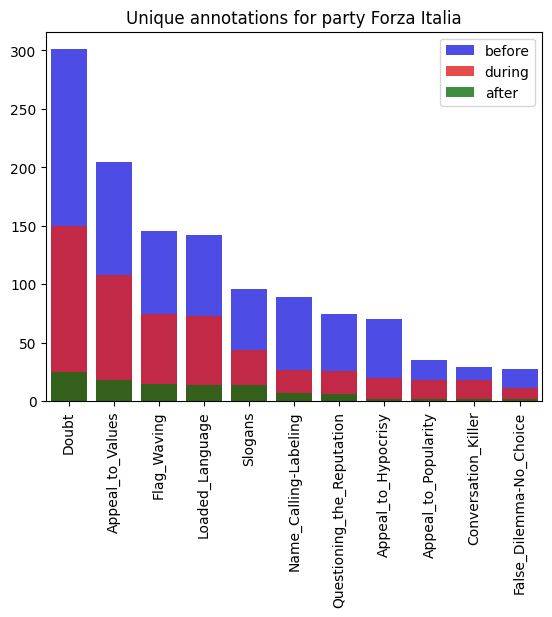

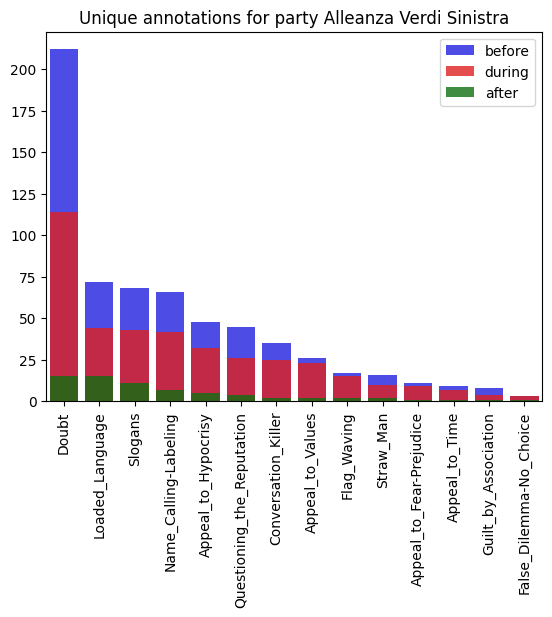

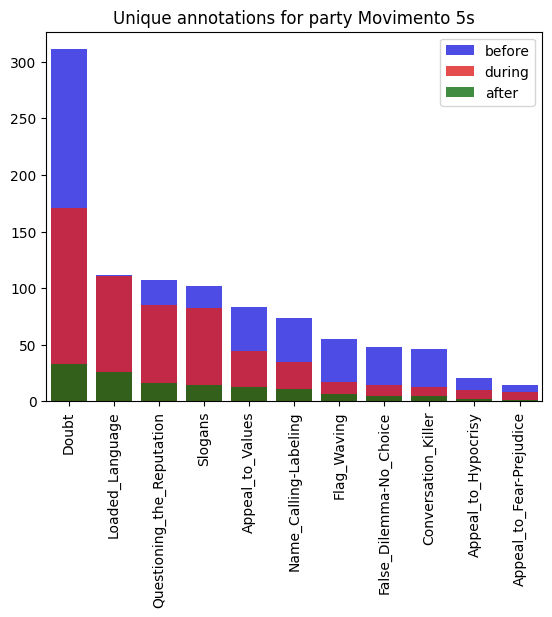

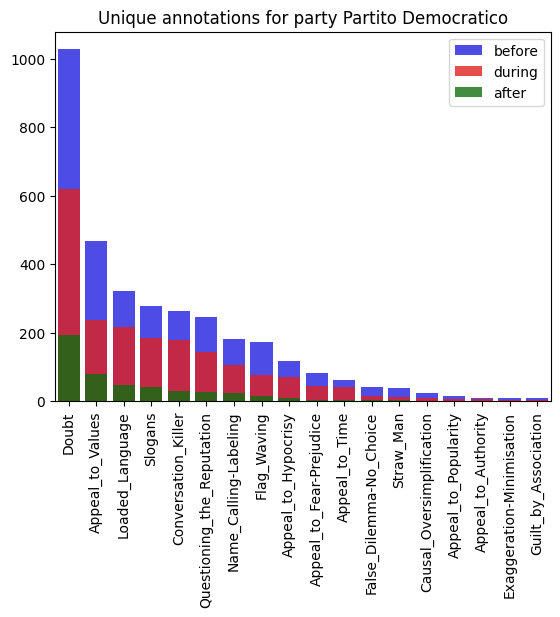

In [17]:
for party in df["Party"].unique():
    # before
    party_annotations_before = before[before["Party"] == party]["unique_annotations"].explode().value_counts()
    # during
    party_annotations_during = during[during["Party"] == party]["unique_annotations"].explode().value_counts()
    # after
    party_annotations_after = after[after["Party"] == party]["unique_annotations"].explode().value_counts()


    # barplots
    sns.barplot(x=party_annotations_before.index, y=party_annotations_before.values, color='blue', label='before', alpha=0.8)
    sns.barplot(x=party_annotations_during.index, y=party_annotations_during.values, color='red', label='during', alpha=0.8)
    sns.barplot(x=party_annotations_after.index, y=party_annotations_after.values, color='green', label='after', alpha=0.8)

    plt.title('Unique annotations for party '+party)
    plt.legend();
    plt.xticks(rotation=90)
    plt.show()